In [1]:
import os
import pandas as pd
import chardet
import numpy as np

# Указываем строку, с которой начинается чтение данных
SRART_ROW = 36  # Нумерация с нуля, поэтому 36 строка в файле - это индекс 35

# Какие скорости нагрева представленны в экспериментальных данных и в каком порядке
heating_rates = ['3', '10', '5']

# Указываем названия колонок
column_names = ['temperature'] + heating_rates

# Указываем путь к папке
folder_path = "TGA"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")
    
# Выбираем первый файл из списка
default_file = file_list[0]

# Определяем кодировку файла
with open(os.path.join(folder_path, default_file), 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

# Считывание данных из CSV файла
df = pd.read_csv(
    os.path.join(folder_path, default_file),
    skiprows=SRART_ROW,
    names=column_names,
    delimiter=';',
    decimal=',',
    encoding=file_encoding,
    dtype=str  # Прочитать все данные как строки
)

# Замена запятых на точки и преобразование в числа
df = df.apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce'))

# Удаление строк с NaN значениями
df.dropna(inplace=True)

# Устанавливаем колонку 'temperature' в качестве индекса
df.set_index('temperature', inplace=True)

# Сортировка столбцов DataFrame по heating_rates
heating_rates.sort(key=int)  # сортировка элементов списка как целых чисел
df = df[heating_rates]  # переупорядочивание столбцов DataFrame

# Вывод первых пяти строк данных
df.head()

,3,5,10
temperature,,,
31.63192,99.99894,100.07588,99.96317
32.58683,99.99902,100.04476,99.97090
33.54175,100.00064,100.03758,99.97650
34.49666,100.00060,100.03165,99.98113
35.45158,99.99498,100.03084,99.97782


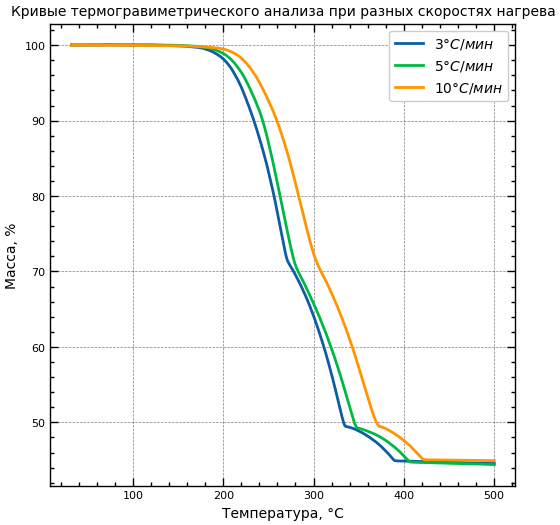

In [2]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# задаём константы для графиков
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8

# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))

axes.plot(df.index, df['3'], label=r'$3°C/мин$')
axes.plot(df.index, df['5'], label=r'$5°C/мин$')
axes.plot(df.index, df['10'], label=r'$10°C/мин$')

# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)
# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа при разных скоростях нагрева', fontsize=MEDIUM_SIZE)
# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

plt.show()

Находим температуры при которых заканчиваются одни реакции и начинаются другие

,start,peak_1,peak_2,peak_3,end
3,181.55357,271.31558,334.33997,390.67996,415.50775
5,189.19289,277.99999,346.75387,406.91351,431.74130
10,204.47153,299.96303,367.76200,422.19215,447.01994


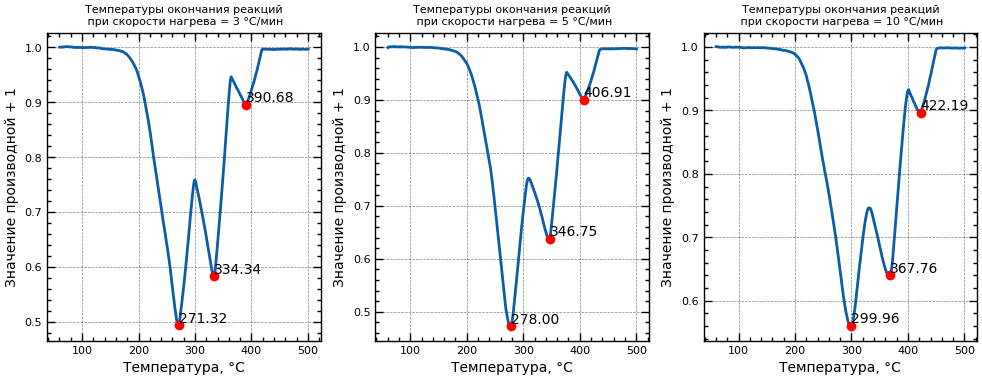

In [3]:
# Определение размера окна для сглаживания
window_size = 30

def find_peaks(df):
    positive_mask = df > 0
    positive_after_negative_mask = positive_mask & (~positive_mask.shift(1, fill_value=True))
    return df[positive_after_negative_mask]

# Инициализация датафрейма с границами начала и конца реакций
peaks_df = pd.DataFrame()

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

for idx, heating_rate in enumerate(heating_rates):
    # Сглаживание данных с использованием скользящего среднего
    smoothed_df = df[heating_rate].rolling(window_size).mean()

    # Расчет дифференциала (первой производной) для сглаженных данных
    diff_df = smoothed_df.diff()

    # Более явно подсвечиваем точки перегиба функции
    curve_turn_points = 1 + diff_df

    # Находим температуры при которых реакции начинаются и заканчиваются
    t_start = curve_turn_points[curve_turn_points < 0.985].index.min()
    t_end = curve_turn_points[curve_turn_points < 0.985].index.max()

    # Находим температуры пиков
    peaks = find_peaks(curve_turn_points[(curve_turn_points.index > t_start) & (curve_turn_points.index < t_end)].diff())

    # Обновляем столбцы в датафрейме для каждого heating_rate и заполняем NaN
    columns = ['start'] + [f'peak_{i+1}' for i in range(len(peaks))] + ['end']
    for column in columns:
        if column not in peaks_df.columns:
            peaks_df[column] = np.nan

    peaks_df.at[heating_rate, 'start'] = t_start
    peaks_df.at[heating_rate, 'end'] = t_end
    for i, peak in enumerate(peaks.index):
        peaks_df.at[heating_rate, f'peak_{i+1}'] = peak

    axes[idx].plot(df.index, curve_turn_points)

    # Добавляем заголовок
    axes[idx].set_title(f'Температуры окончания реакций\n при скорости нагрева = {heating_rate} °C/мин', fontsize=SMALL_SIZE)

    # Добавляем подписи на оси
    axes[idx].set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
    axes[idx].set_ylabel('Значение производной + 1', fontsize=MEDIUM_SIZE)

    # Настраиваем размер легенды и подписей осей
    axes[idx].tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

    # Выделяем и подписываем точки на графике
    for index in peaks.index:
        peak_value = curve_turn_points[index]
        axes[idx].plot(index, peak_value, 'ro')
        axes[idx].text(index, peak_value, f'{index:.2f}', fontsize=10, ha='left', va='bottom')

peaks_df

Разделяем поле температур на области реакций

In [4]:
# Цикл по скоростям нагрева
for rate in heating_rates:
    # Получаем значения пиков для текущей скорости нагрева
    peaks = peaks_df.loc[rate]

    # Создаем список всех пиков, включая старт и финиш
    peaks_list = [peaks['start']] + [peaks[col] for col in peaks_df.columns if 'peak' in col] + [peaks['end']]

    # Функция для определения реакции
    def get_reaction(temp):
        for i in range(len(peaks_list) - 1):
            if peaks_list[i] <= temp < peaks_list[i + 1]:
                return f'reaction_{i}'
        return 'no_reaction'

    # Применяем функцию к индексу df и создаем новый столбец
    df['reactions_' + str(rate)] = df.index.to_series().apply(get_reaction)

Находим степень конверсии для каждой реакции в каждом значении температуры

In [5]:
for rate in heating_rates:
    reaction_col = f'reactions_{rate}'
    heating_rate_col = f'{rate}'
    conversion_col = f'conversion_{rate}'

    # Получаем начальные и конечные значения температуры для каждой реакции
    df_temp = df[df[reaction_col] != 'no_reaction']
    min_max_mass = df_temp.groupby(reaction_col)[heating_rate_col].agg(['min', 'max'])

    # Создаем новый столбец с нулевыми значениями
    df[conversion_col] = 0

    # Расчет степени превращения для каждой реакции
    for reaction in min_max_mass.index:
        reaction_mask = df[reaction_col] == reaction
        min = min_max_mass.loc[reaction, 'min']
        max = min_max_mass.loc[reaction, 'max']
        df.loc[reaction_mask, conversion_col] = 1 - (df.loc[reaction_mask, heating_rate_col] - min) / (max - min)


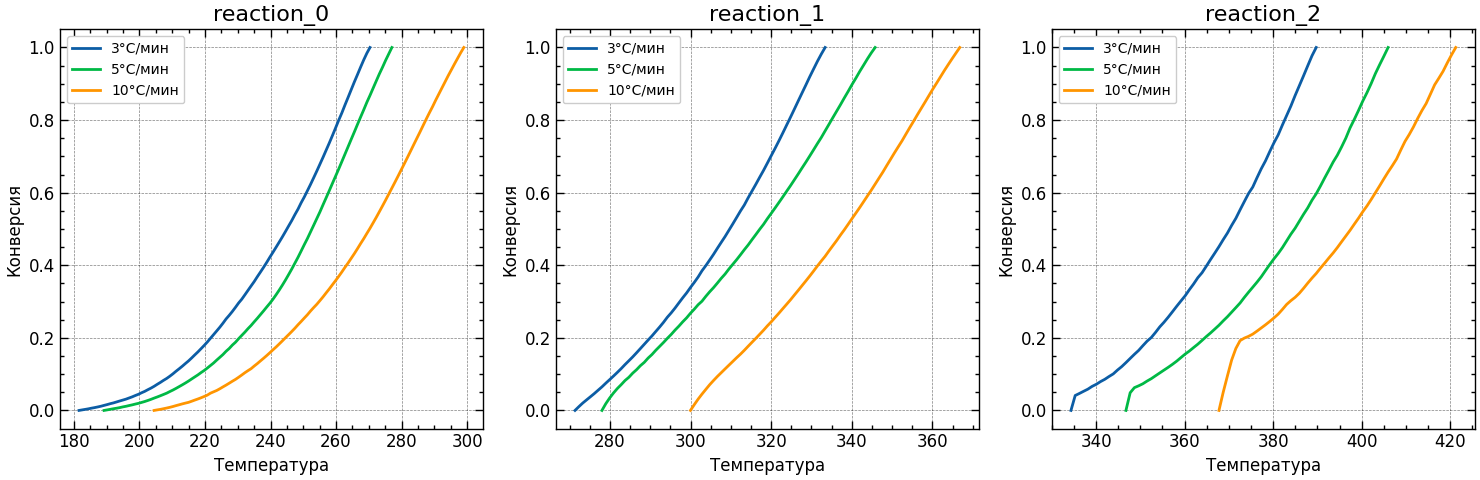

In [6]:
# Получаем уникальные реакции, исключая 'no_reaction', из всех столбцов reactions
all_reactions = pd.unique(df[[f'reactions_{rate}' for rate in heating_rates]].values.ravel())
all_reactions = all_reactions[all_reactions != 'no_reaction']

# Отбрасываем последнюю реакцию
all_reactions = all_reactions[:-1]

# Создайте фигуру с несколькими подграфиками
fig, axs = plt.subplots(1, len(all_reactions), figsize=(5 * len(all_reactions), 5))

# Если есть только одна реакция, axs не будет списком, поэтому обработаем этот случай
if len(all_reactions) == 1:
    axs = [axs]

# Строим графики для каждой реакции
for ax, reaction in zip(axs, all_reactions):
    for rate in heating_rates:
        conversion_col = f'conversion_{rate}'
        reactions_col = f'reactions_{rate}'
        mask = df[reactions_col] == reaction
        if mask.any():
            ax.plot(df.loc[mask].index, df.loc[mask, conversion_col], label=f'{rate}°С/мин')
    ax.set_title(reaction)
    ax.set_xlabel('Температура', fontsize=BIG_SIZE)
    ax.set_ylabel('Конверсия', fontsize=BIG_SIZE)
    # Настраиваем размер легенды и подписей осей
    ax.legend(loc='upper left', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=BIG_SIZE)

plt.tight_layout()
plt.show()


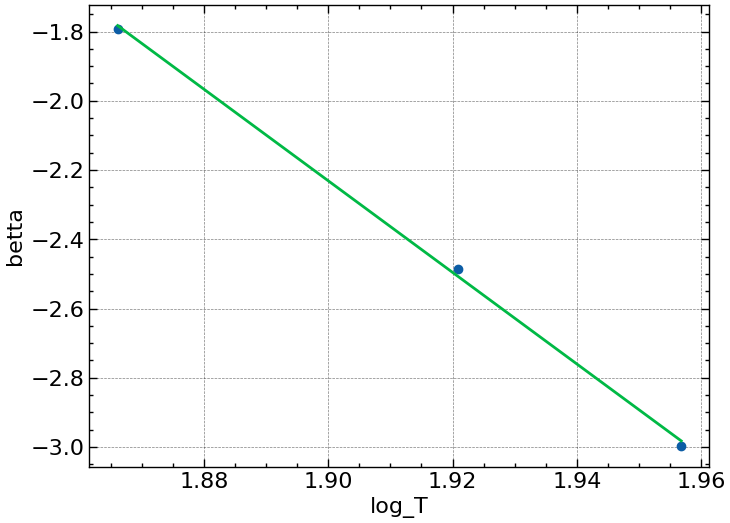

In [38]:
betta = [np.log(int(rate)/60) for rate in heating_rates]

log_T = [
    1000 / ((df[df[f'reactions_{rate}'] == 'reaction_0'][f'conversion_{rate}'] - 0.4).abs().idxmin() + 273.15)
    for rate 
    in heating_rates]

# betta = [0, 0.3, 0.6, 0.9, 1.2]
# log_T = [3.1, 3.05, 2.99, 2.94, 2.89]

coefficient = np.polyfit(log_T, betta, 1)

plt.plot(log_T, betta, 'o', label='')  


x_values = np.linspace(np.min(log_T), np.max(log_T), 100)
y_values = np.polyval(coefficient, x_values)
plt.plot(x_values, y_values, label='')

plt.xlabel('log_T')
plt.ylabel('betta')

plt.show()


In [40]:
coefficient[0] * 8.314462618 / -1.05

104.74959227930783

In [35]:
temps = [5, 10, 25, 40]
temps = [temp/60 for temp in temps]
log_templs = [np.log(temp) for temp in temps]
log_templs

[-2.4849066497880004,
 -1.791759469228055,
 -0.8754687373538999,
 -0.40546510810816444]

In [34]:
0.457*2.3

1.0511

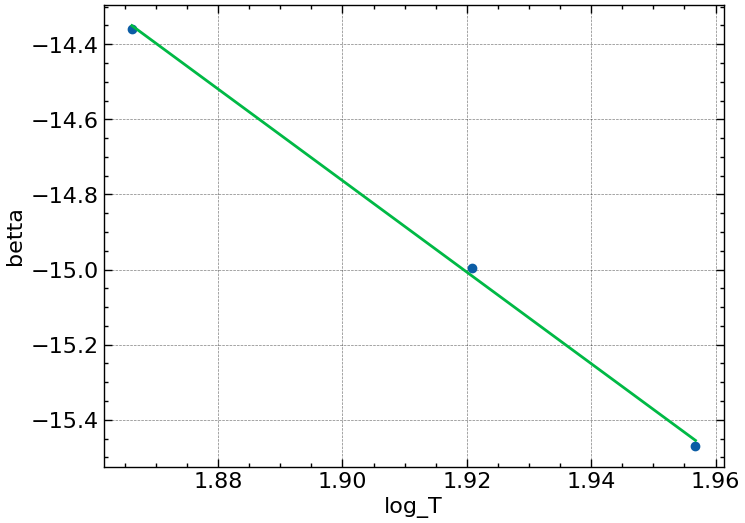

In [36]:
betta = [
    np.log(
        int(rate)/60
        /((df[df[f'reactions_{rate}'] == 'reaction_0'][f'conversion_{rate}'] - 0.4).abs().idxmin() 
          + 273.15)**2)
         for rate in heating_rates]

log_T = [
    1000 / ((df[df[f'reactions_{rate}'] == 'reaction_0'][f'conversion_{rate}'] - 0.4).abs().idxmin() + 273.15)
    for rate 
    in heating_rates]

# betta = [0, 0.3, 0.6, 0.9, 1.2]
# log_T = [3.1, 3.05, 2.99, 2.94, 2.89]

coefficient = np.polyfit(log_T, betta, 1)

plt.plot(log_T, betta, 'o', label='')  


x_values = np.linspace(np.min(log_T), np.max(log_T), 100)
y_values = np.polyval(coefficient, x_values)
plt.plot(x_values, y_values, label='')

plt.xlabel('log_T')
plt.ylabel('betta')

plt.show()

In [37]:
-coefficient[0] * 8.314462618

101.27907028553936